In [1]:
import os 
import cv2

from PIL import Image, ImageFont, ImageDraw
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.interpolate import LinearNDInterpolator

In [2]:
toPILImage = transforms.ToPILImage()
toTensor = transforms.ToTensor()


def load_gt_disp_kitti(path):
    """
    Loads in the ground truth files from the KITTI Stereo Dataset

    Args:
        -path (string): path to the the training files

    Returns:
        -gt_disparities (list): list of ground truth disparities
    """
    gt_disparities = []
    for i in range(200):
        disp = cv2.imread(
                path + "/training/disp_noc_0/" + str(i).zfill(6) + "_10.png", -1
        )
        disp = disp.astype(np.float32) / 256
        gt_disparities.append(disp)
    return gt_disparities

def load_kitti_image(path,index,resize = True, asTensor = False):
    """
    Loads in the images from the KITTI Stereo Dataset

    Args:
        -path (string): path to the the training files
        -resize (string): left or right camera 

    Returns:
        -images (list): list of images
    """
    size = (256, 512)
    
    left_image = Image.open(path + "/training/image_2/" + str(index).zfill(6) + "_10.png")
    right_image = Image.open(path + "/training/image_3/" + str(index).zfill(6) + "_10.png")
    
    if resize:
        resize = transforms.Resize(size)
        left_image = resize(left_image)
        right_image = resize(right_image)
        
        
    if asTensor:
        toTensor = transforms.ToTensor()
        left_image = toTensor(left_image)
        right_image = toTensor(right_image)

    return left_image, right_image 
    

def load_pred_disp(path, resize = False):
    """ 
     
    """
    
    disp = np.load(path)
    height, width = (375, 1242)
    
    if resize:
        resized_disp = []
        for i in range(disp.shape[0]):
            resized_disp.append(width * cv2.resize(disp[i], (width, height), interpolation=cv2.INTER_LINEAR))
        disp = resized_disp 
        
    return disp 

def sigmoid(x):
   return 1 / (1 + np.exp(x))

def lin_interp(image):
    """ Linearly interpolates the depth data to fill zero holes - adapted from https://github.com/hunse/kitti

    Args:
        -shape(tuple): size of the image
        -xyd (np array):

    Returns:
        -points (2D): points
    """

    shape = image.shape
    m, n = shape
    ij = np.matrix(np.nonzero(image)).T
    d = image[np.nonzero(image)]

    f = LinearNDInterpolator(ij, d, fill_value=0)
    J, I = np.meshgrid(np.arange(n), np.arange(m))
    IJ = np.vstack([I.flatten(), J.flatten()]).T
    disparity_interpolated = f(IJ).reshape(shape)

    return disparity_interpolated

def plot_disparity_map(disp,showFigure=True): 
    ymax, xmax = disp.shape
    dpi = ymax
    #fig = plt.figure(figsize=(8, 4), frameon=False)
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0, 0, 1, 1])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(disp, aspect="auto", cmap="plasma")
    
    if showFigure:
        plt.show()
    
    return fig 
    
    
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

def fig2img ( fig ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape
    return Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) )

def convert_disps_to_depths_kitti(gt_disparities, pred_disparities):
        """
        Converts the ground truth disparities from the KITTI Stereo dataset and the predictions to depth values

        Args:
         -gt_disparities (list): ground truth disparities
         -pred_disparities (list): predicted disparities

        Returns:
         -gt_depths (list): list of ground truth depths
         -pred_depths (list): list of predicted depths
         -pred_depths_resized (list): list of predicted depths, resized to ground truth disparity size

        """
        gt_depths = []
        pred_depths = []
        pred_disparities_resized = []

        
        width_to_focal = dict()
        width_to_focal[1242] = 721.5377
        width_to_focal[1241] = 718.856
        width_to_focal[1224] = 707.0493
        width_to_focal[1238] = 718.3351
        
        
        for i in range(len(gt_disparities)):
            gt_disp = gt_disparities[i]
            height, width = gt_disp.shape

            pred_disp = pred_disparities[i]
            pred_disp = width * cv2.resize(
                pred_disp, (width, height), interpolation=cv2.INTER_LINEAR
            )

            pred_disparities_resized.append(pred_disp)

            mask = gt_disp > 0

            gt_depth = width_to_focal[width] * 0.54 / (gt_disp + (1.0 - mask))
            pred_depth = width_to_focal[width] * 0.54 / pred_disp

            gt_depths.append(gt_depth)
            pred_depths.append(pred_depth)

        return gt_depths, pred_depths, pred_disparities_resized
    
    
def apply_disparity(img, disp):
        """ Applies a disparity map to an image.

        Args:
            img: (n_batch, n_dim, nx, ny) input image
            disp: (n_batch, 1, nx, ny) disparity map to be applied

        Returns:
            the input image shifted by the disparity map (n_batch, n_dim, nx, ny)
        """
        
        width,height = right_image.size
        img = transforms.ToTensor()(right_image).unsqueeze(0)
        disp = torch.tensor(disp)

        device = torch.device('cpu')
        
        # Original coordinates of pixels
        x_base = (
            torch.linspace(0, 1, width)
            .repeat(1,height, 1)
            .type_as(img)
            .to(device)
        )
        y_base = (
            torch.linspace(0, 1, height)
            .repeat(1,width, 1)
            .transpose(1, 2)
            .type_as(img)
        ).to(device)

        # Apply shift in X direction
        x_shifts = disp[:, :]  # Disparity is passed in NCHW format with 1 channel
        flow_field = torch.stack((x_base + x_shifts, y_base), dim=3)

        # In grid_sample coordinates are assumed to be between -1 and 1
        output = F.grid_sample(img, 2 * flow_field - 1, mode="bilinear", padding_mode="zeros")

        return output.squeeze()

In [ ]:
#folder structure 
#have the images in data/kitti

#milestones folder 
files = os.listdir('data/output/milestones/aspp-modules/')
experiments = {}

for experiment in files: 
    path = 'data/output/milestones/aspp-modules/{}/test/disparities.npy'.format(experiment)
    experiments[experiment] = pred_disp_resized = load_pred_disp('data/output/milestones/aspp-modules/1/test/disparities.npy',resize=True)

In [ ]:
os.listdir('data/output/milestones/aspp-modules/')

In [3]:
#loading disparity data and generating depth maps
kitti_gt_disp = load_gt_disp_kitti('data/kitti')

#load data for a specific experiment 
pred_disp = load_pred_disp('data/output/milestones/aspp-modules/1/test/disparities.npy')
pred_disp_resized = load_pred_disp('data/output/milestones/aspp-modules/1/test/disparities.npy',resize=True)
gt_depths, pred_depths, pred_depths_resized = convert_disps_to_depths_kitti(kitti_gt_disp,pred_disp)

#how to load single images (as PIL or Tensor) - set asTensor = true 
left_image, right_image   = load_kitti_image('data/kitti', index = 0, resize=True)
left_tensor, right_tensor = load_kitti_image('data/kitti', index = 0, resize=True, asTensor=True)

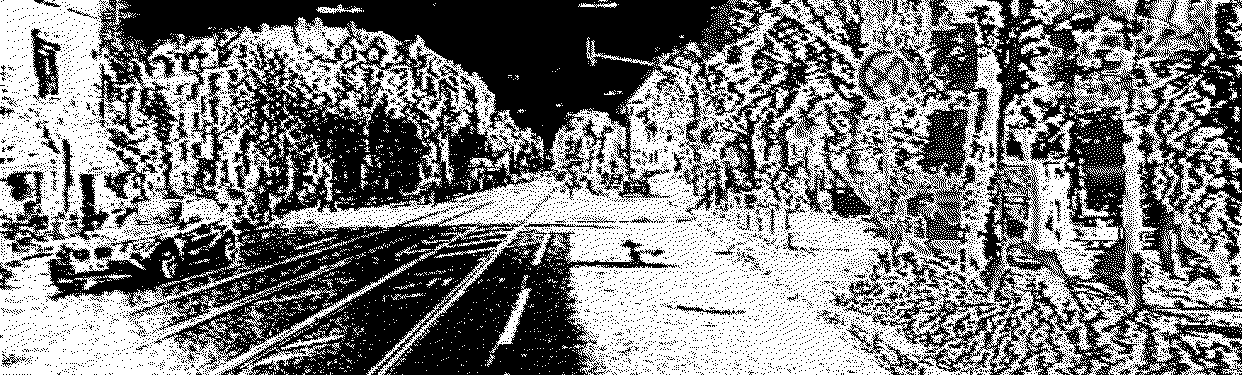

In [10]:
#reconstruction error plots

#get the images from dataset
i = 1 #image index
left_image, right_image   = load_kitti_image('data/kitti', index = i, resize=True)
left_tensor, right_tensor = load_kitti_image('data/kitti', index = i, resize=True, asTensor=True)

#apply the left disparity map to the right_image
output = apply_disparity(right_image, - pred_disp[i])

#resize and output image
final = transforms.ToPILImage()(output-left_tensor)
final = transforms.Resize(size=(375,1242))(final)
final.convert('1')

In [ ]:
#Difference Maps between ground truth and predicted disparities (masked at the available pixels)
i = 0 #image index
gt = kitti_gt_disp[i]
pred = pred_disp_resized[i]
left_image, right_image   = load_kitti_images('data/kitti', index = i, resize=True)

mask = gt > 0
pred[np.logical_not(mask)] = 0

#plot_disparity_map(gt)
#plot_disparity_map(pred)

diff = np.abs(gt-pred)
plot_disparity_map(diff)

#TODO find appropiate way to visualize magnitude of error (in dense disparity map or in original image)
diff_mask = diff < 1
diff[diff_mask] = 0
plot_disparity_map(diff**0.75)
hist = plt.hist(difference_values)
plt.show()

In [ ]:
#interpolation of disparity maps 
gt_disp = kitti_gt_disp[0]

disparity_interpolated = lin_interp(image)
disparity_sparse = image

plot_disparity_map(disparity_sparse)
plot_disparity_map(disparity_interpolated)

In [ ]:
#folder structure 
#have the images in data/kitti

#milestones folder 
files = os.listdir('data/output/milestones/aspp-modules/')
experiments = {}
num_experiments = len(files)

for experiment in files: 
    path = 'data/output/milestones/aspp-modules/{}/test/disparities.npy'.format(experiment)
    experiments[experiment] = pred_disp_resized = load_pred_disp('data/output/milestones/aspp-modules/1/test/disparities.npy',resize=True)

image_idx = 0 

In [ ]:
for experiment in experiments.keys():
    print(experiment)
    pred = experiments[experiment]
    pred = pred_disp_resized[image_idx]
    left_image, right_image   = load_kitti_images('data/kitti', index = i, resize=True)

    mask = gt > 0
    pred[np.logical_not(mask)] = 0
    
    diff = np.abs(gt-pred)

    
    diff = np.abs(gt-pred)
    plot_disparity_map(diff)

In [7]:
def evaluate_experiment(experiment_name):
    experiment_folder = 'data/output/milestones/{}/'.format(experiment_name)
    files = [f for f in os.listdir(experiment_folder) if not f.startswith('.')]
    num_experiments = len(files)
    
    experiments = {}
    for experiment in files: 
        path = experiment_folder + '{}/test/disparities.npy'.format(experiment)
        experiments[experiment] = load_pred_disp(path,resize=True)

    width = 1242
    total_height = 375 * (num_experiments+1)
    output_dir = os.path.join('data','output', 'report_disparity_error', experiment_name)

    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    try:
        fnt = ImageFont.truetype("/Library/Fonts/Arial.ttf", 15)
    except OSError:
        fnt = ImageFont.truetype("/usr/share/fonts/truetype/open-sans/OpenSans-Regular.ttf", 15)

    for i in range(200):
        #load image and ground truth 
        img, right_img = load_kitti_image(path='data/kitti', index=i, resize=False)
        gt = kitti_gt_disp[i]

        new_im = Image.new("RGB", (width, total_height))
        new_im.paste(img, (0, 0))

        for j, experiment in enumerate(experiments):
            description = experiment_name + ': ' + experiment
            pred = experiments[experiment][i]
                        
            #skip those that are not of the same size as the prediction
            if(gt.shape[0] != 375): 
                print(gt.shape)
                print(pred.shape)
                continue 

            #get the sparse pixels and calculate difference 
            mask = gt > 0
            pred[np.logical_not(mask)] = 0
            diff = np.abs(gt-pred)
            diff = diff / np.max(diff)

            fig = Image.fromarray(np.uint8(cm.plasma(diff)*255))
            #create figure and convert to PIL image
            #fig = plot_disparity_map(diff, showFigure=False)
            #fig = fig2img(fig)

            #label the image
            d = ImageDraw.Draw(fig)
            d.text((10, 350), description, font=fnt, fill=(255, 255, 255))

            new_im.paste(fig, (0, (j + 1) * 375))

        concat_outfile = "concat_{}.png".format(str(i).zfill(3))
        concat_outfile = os.path.join(output_dir, concat_outfile)
        new_im.save(concat_outfile)

In [8]:
exps = [f for f in os.listdir('data/output/milestones/') if not f.startswith('.')]
print(exps)
for exp in exps:
    evaluate_experiment(exp)

['aspp-modules', 'aspp-rates', 'city2kitti-milestones', 'output-stride', 'skips-aspp']
(370, 1224)
(375, 1242)
(370, 1224)
(375, 1242)
(370, 1224)
(375, 1242)
(370, 1224)
(375, 1242)
(370, 1224)
(375, 1242)
(370, 1224)
(375, 1242)
(370, 1224)
(375, 1242)
(370, 1224)
(375, 1242)
(370, 1224)
(375, 1242)
(370, 1224)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(

(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(370, 1224)
(375, 1242)
(370, 1224)
(375, 1242)
(370, 1224)
(375, 1242)
(370, 1224)
(375, 1242)
(370, 1224)
(375, 1242)
(370, 1224)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375

(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(374, 1238)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375, 1242)
(376, 1241)
(375